In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab 

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

In [2]:
#Load the dataset
df_data=pd.read_csv('Car_details.csv')
df_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
#Check the data-type of each feature
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
name             8128 non-null object
year             8128 non-null int64
selling_price    8128 non-null int64
km_driven        8128 non-null int64
fuel             8128 non-null object
seller_type      8128 non-null object
transmission     8128 non-null object
owner            8128 non-null object
mileage          7907 non-null object
engine           7907 non-null object
max_power        7913 non-null object
torque           7906 non-null object
seats            7907 non-null float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [4]:
#Get the total number of rows and columns in dataset
df_data.shape

(8128, 13)

## Impute missing values

In [5]:
#Functon to get count of missing values in each column
def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]

In [6]:
print('Features having missing values are:')
print(get_cols_with_missing_values(df_data))

Features having missing values are:
mileage      221
engine       221
max_power    215
torque       222
seats        221
dtype: int64


In [7]:
#The 'mileage' feature has object data-type 
#The feature comprises of mileage number and the unit
#We will create a new feature named 'mileage_number' to get the actual number
#221/8128 values are missing - we will first create the above mentioned new feature and then impute the missing values

df_data[['mileage_number', 'mileage_unit']] = df_data['mileage'].str.split(' ', 1, expand=True)
df_data.drop(['mileage_unit', 'mileage'],axis=1,inplace=True)

df_data['mileage_number']=df_data['mileage_number'].astype('float')

#impute the missing values
df_data['mileage_number']=df_data['mileage_number'].fillna(df_data['mileage_number'].mean())

In [8]:
#The 'engine' feature has object data-type 
#The feature comprises of a number and a unit
#We will create a new feature named 'engine_op_number' to get the actual number
#221/8128 values are missing - we will first create the above mentioned new feature and then impute the missing values

df_data[['engine_op_number', 'engine_op_unit']] = df_data['engine'].str.split(' ', 1, expand=True)
df_data.drop(['engine_op_unit', 'engine'],axis=1,inplace=True)

df_data['engine_op_number']=df_data['engine_op_number'].astype('float')

#impute the missing values
df_data['engine_op_number']=df_data['engine_op_number'].fillna(df_data['engine_op_number'].mean())

In [9]:
#The 'max_power' feature has object data-type 
#The feature comprises of a number and a unit
#We will create a new feature named 'max_power_number' to get the actual number
#221/8128 values are missing - we will first create the above mentioned new feature and then impute the missing values

df_data[['max_power_number', 'max_power_unit']] = df_data['max_power'].str.split(' ', 1, expand=True)
df_data.drop(['max_power_unit', 'max_power'],axis=1,inplace=True)

df_data['max_power_number'].replace({'': 0}, inplace=True)

df_data['max_power_number'] = df_data['max_power_number'].fillna(df_data['max_power_number'].mode()[0])

df_data['max_power_number']=df_data['max_power_number'].astype('float')

In [10]:
#torque feature
df_data[['torque', 'torque_remainder']] = df_data['torque'].str.split('@', 1, expand=True)
df_data.drop(['torque_remainder'],axis=1,inplace=True)

df_data['torque']= df_data['torque'].str.extract('(^\d*)')

df_data['torque']= df_data['torque'].fillna(150)
df_data['torque']=df_data['torque'].astype('int')

#if it's in kgm, change it to N.m by multiplying by g= 9.8 -> 1 kg-m is equal to 9.80665 newton meter.
df_data['torque'] = df_data['torque'].apply(lambda x: 9.8*x if x <= 50 else x)

In [11]:
#seats feature
df_data['seats']=df_data['seats'].fillna(df_data['seats'].mean())

In [12]:
#Drop the name feature
df_data.drop(['name'], axis=1, inplace=True)

In [13]:
#Get categorical and numerical columns
categorical_cols=[cname for cname in df_data.columns if df_data[cname].dtypes=='object']
numerical_cols=[cname for cname in df_data.columns if df_data[cname].dtypes!='object']

In [14]:
print('Categorical features:',categorical_cols,'\n')
print('Numerical features:',numerical_cols)

Categorical features: ['fuel', 'seller_type', 'transmission', 'owner'] 

Numerical features: ['year', 'selling_price', 'km_driven', 'torque', 'seats', 'mileage_number', 'engine_op_number', 'max_power_number']


In [15]:
#seller_type
df_data.seller_type = df_data.seller_type.apply(lambda x: 'Trustmark_Dealer' if 'Trustmark Dealer' in x else x)

## EDA

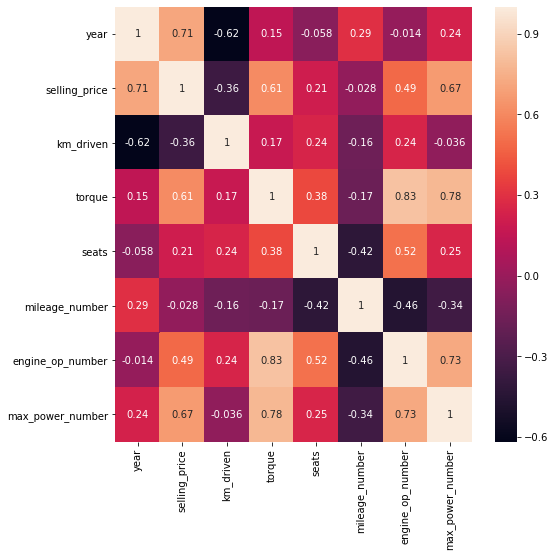

In [16]:
corrmat = df_data.corr(method = "spearman")
plt.figure(figsize=(8,8))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

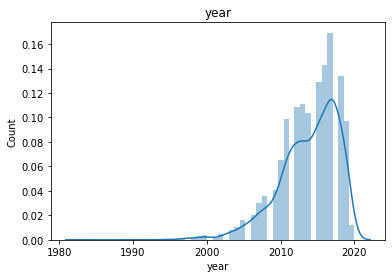

<Figure size 1080x1080 with 0 Axes>

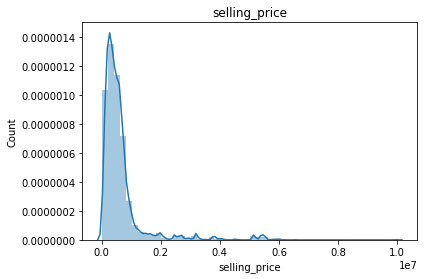

<Figure size 1080x1080 with 0 Axes>

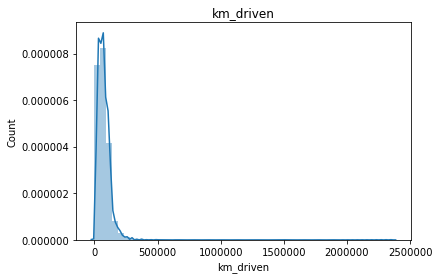

<Figure size 1080x1080 with 0 Axes>

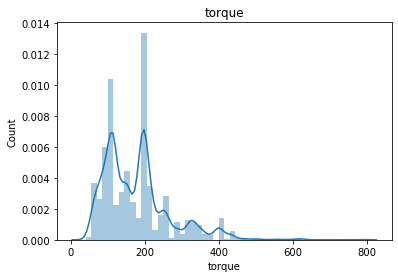

<Figure size 1080x1080 with 0 Axes>

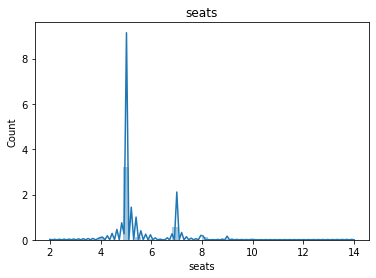

<Figure size 1080x1080 with 0 Axes>

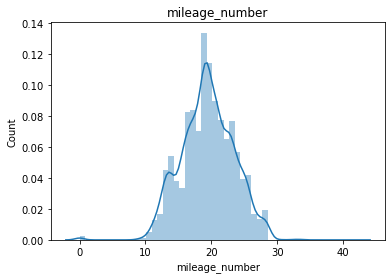

<Figure size 1080x1080 with 0 Axes>

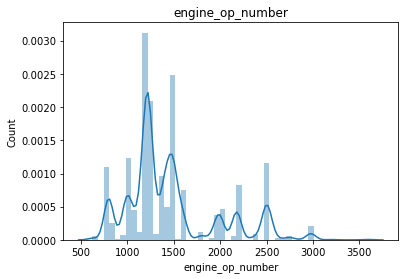

<Figure size 1080x1080 with 0 Axes>

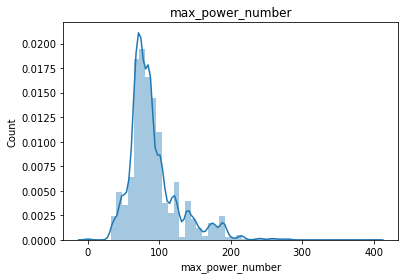

<Figure size 1080x1080 with 0 Axes>

In [17]:
#Numeric data distribution
for feature in numerical_cols:
    sns.distplot(df_data[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

Text(0.5, 1.0, 'Distribution fuel type')

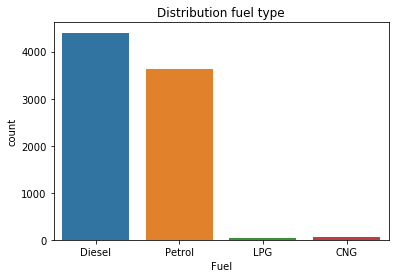

In [18]:
#Distribution fuel type
sns.countplot(x='fuel', data=df_data)
plt.xlabel('Fuel')
plt.title('Distribution fuel type')

Text(0.5, 1.0, 'Seller Type')

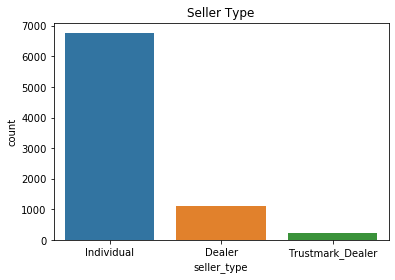

In [19]:
#Seller Type
sns.countplot(x='seller_type', data=df_data)
plt.title('Seller Type')

Text(0.5, 1.0, 'Engine Transmission')

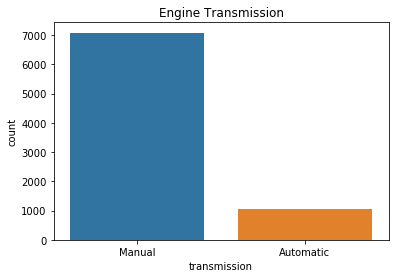

In [20]:
#Engine Transmission
sns.countplot(x='transmission', data=df_data)
plt.title('Engine Transmission')

Text(0.5, 1.0, 'Transmission-fuel')

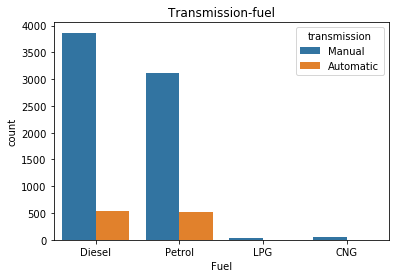

In [21]:
#Transmission-fuel
sns.countplot(x='fuel', data=df_data, hue='transmission')
plt.xlabel('Fuel')
plt.title('Transmission-fuel')

Text(0.5, 1.0, 'Owner')

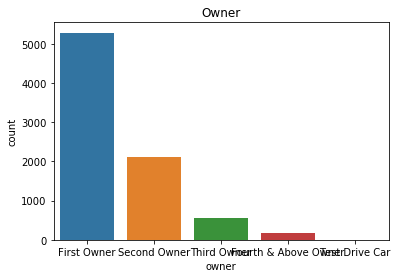

In [22]:
#Engine Transmission
sns.countplot(x='owner', data=df_data)
plt.title('Owner')

## Handling Outliers

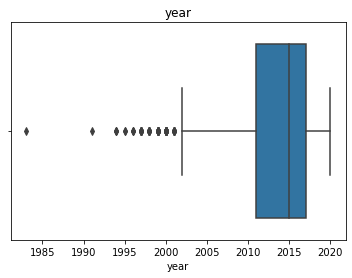

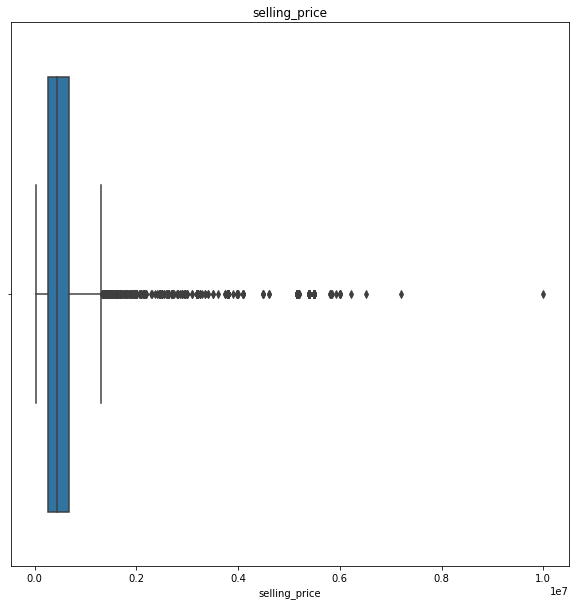

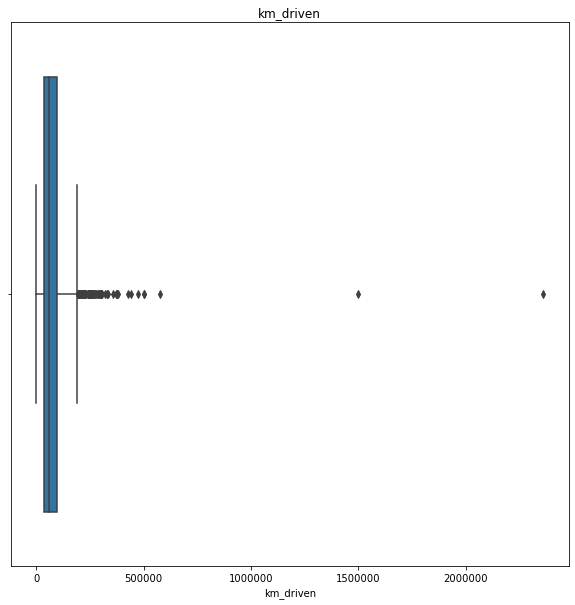

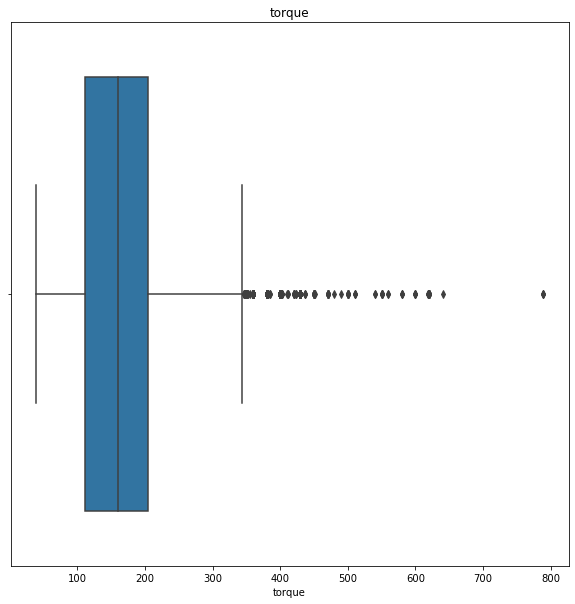

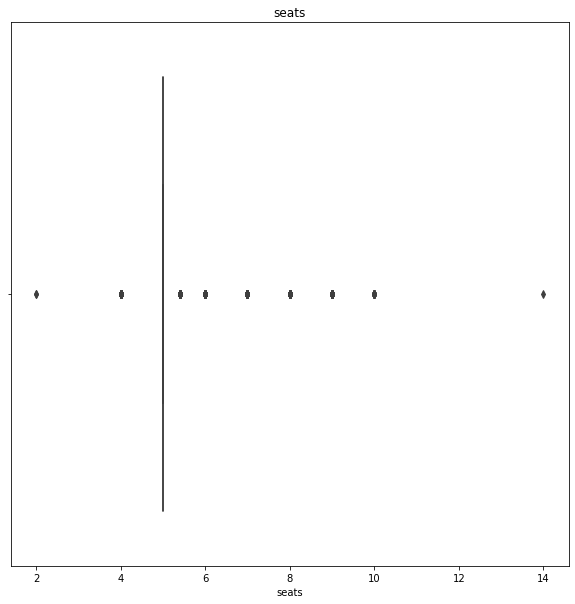

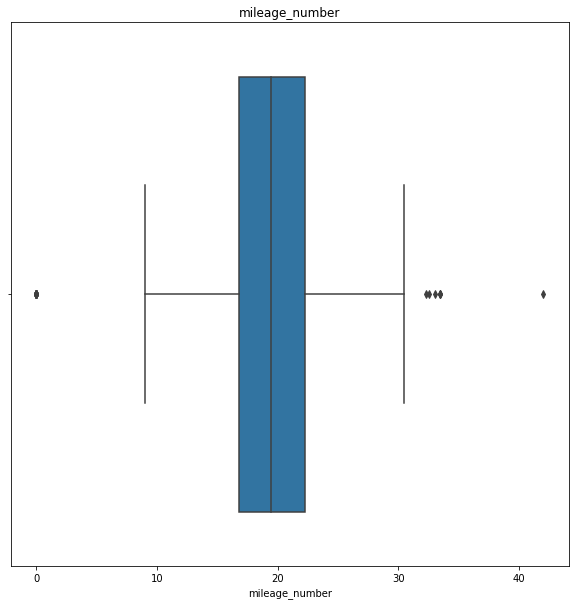

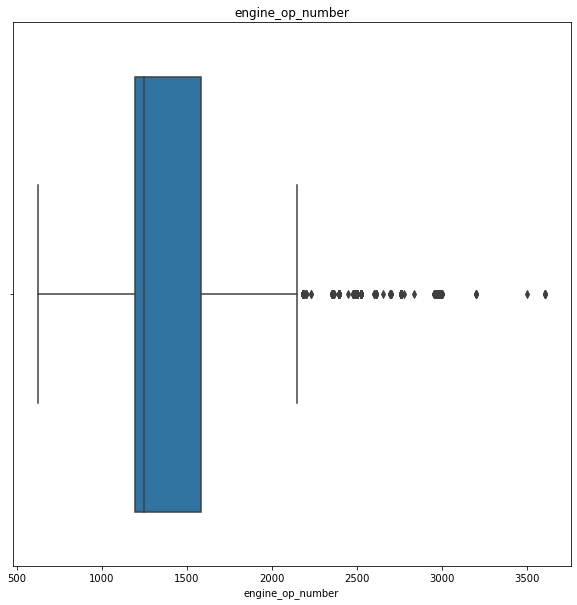

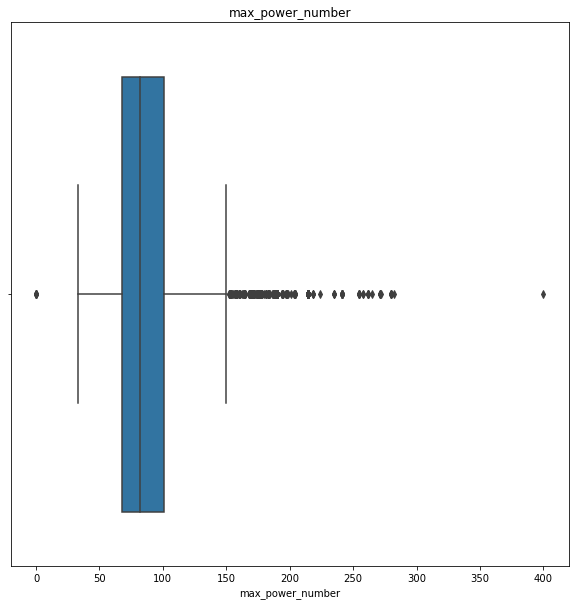

<Figure size 720x720 with 0 Axes>

In [23]:
for feature in numerical_cols:
    sns.boxplot(df_data[feature])
    plt.title(feature)
    plt.figure(figsize=(10,10))

In [24]:
#Handling outliers in 'year'
IQR=df_data.year.quantile(0.75)-df_data.year.quantile(0.25)
lower_limit=df_data.year.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.year.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

2002.0 2026.0


In [25]:
df_data.loc[df_data['year']>=upper_limit,'year']=upper_limit
df_data.loc[df_data['year']<=lower_limit,'year']=lower_limit

In [26]:
#Handling outliers in 'selling_price'
IQR=df_data.selling_price.quantile(0.75)-df_data.selling_price.quantile(0.25)
lower_limit=df_data.selling_price.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.selling_price.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

-375002.5 1305001.5


In [27]:
df_data.loc[df_data['selling_price']>=upper_limit,'selling_price']=upper_limit
df_data.loc[df_data['selling_price']<=lower_limit,'selling_price']=lower_limit

In [28]:
#Handling outliers in 'km_driven'
IQR=df_data.km_driven.quantile(0.75)-df_data.km_driven.quantile(0.25)
lower_limit=df_data.km_driven.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.km_driven.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

-59500.0 192500.0


In [29]:
df_data.loc[df_data['km_driven']>=upper_limit,'km_driven']=upper_limit
df_data.loc[df_data['km_driven']<=lower_limit,'km_driven']=lower_limit

In [30]:
#Handling outliers in 'torque'
IQR=df_data.torque.quantile(0.75)-df_data.torque.quantile(0.25)
lower_limit=df_data.torque.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.torque.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

-27.5 344.5


In [31]:
df_data.loc[df_data['torque']>=upper_limit,'torque']=upper_limit
df_data.loc[df_data['torque']<=lower_limit,'torque']=lower_limit

In [32]:
#Handling outliers in 'mileage_number'
IQR=df_data.mileage_number.quantile(0.75)-df_data.mileage_number.quantile(0.25)
lower_limit=df_data.mileage_number.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.mileage_number.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

8.583750000000002 30.49375


In [33]:
df_data.loc[df_data['mileage_number']>=upper_limit,'mileage_number']=upper_limit
df_data.loc[df_data['mileage_number']<=lower_limit,'mileage_number']=lower_limit

In [34]:
#Handling outliers in 'engine_op_number'
IQR=df_data.engine_op_number.quantile(0.75)-df_data.engine_op_number.quantile(0.25)
lower_limit=df_data.engine_op_number.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.engine_op_number.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

619.5 2159.5


In [35]:
df_data.loc[df_data['engine_op_number']>=upper_limit,'engine_op_number']=upper_limit
df_data.loc[df_data['engine_op_number']<=lower_limit,'engine_op_number']=lower_limit

In [36]:
#Handling outliers in 'max_power_number'
IQR=df_data.max_power_number.quantile(0.75)-df_data.max_power_number.quantile(0.25)
lower_limit=df_data.max_power_number.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.max_power_number.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

18.374999999999986 150.97500000000002


In [37]:
df_data.loc[df_data['max_power_number']>=upper_limit,'max_power_number']=upper_limit
df_data.loc[df_data['max_power_number']<=lower_limit,'max_power_number']=lower_limit

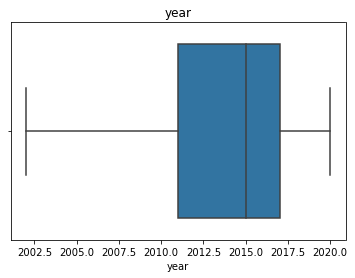

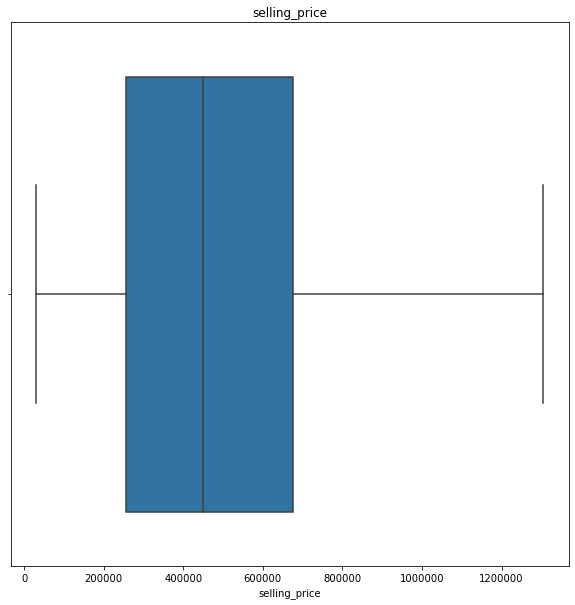

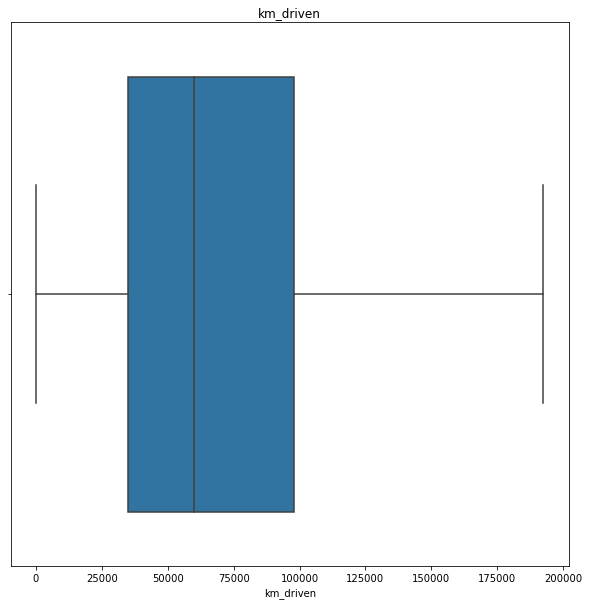

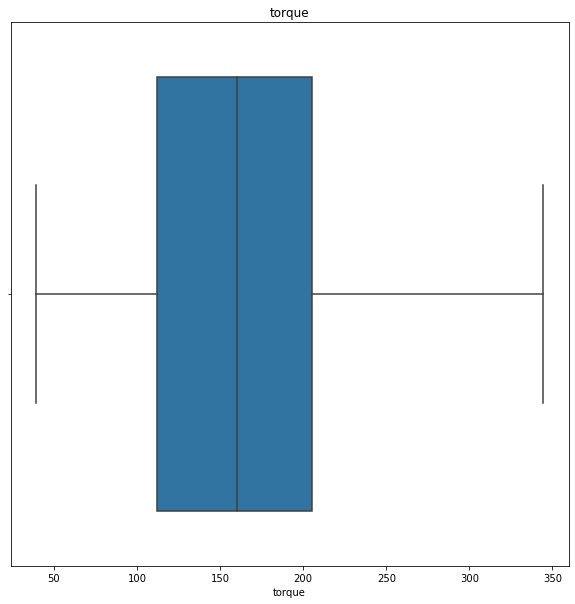

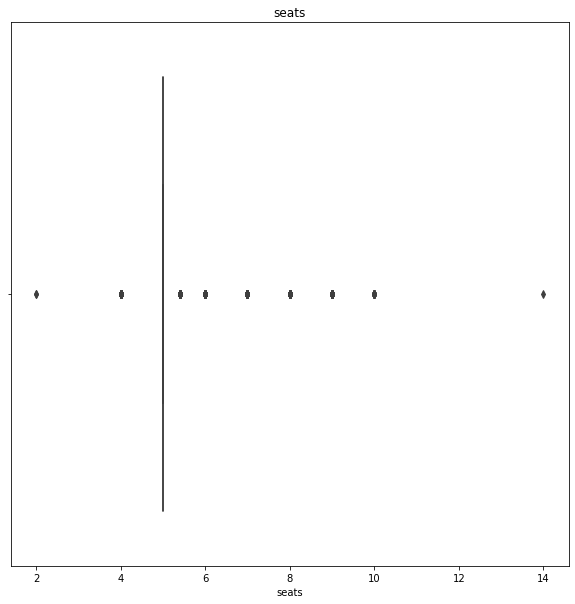

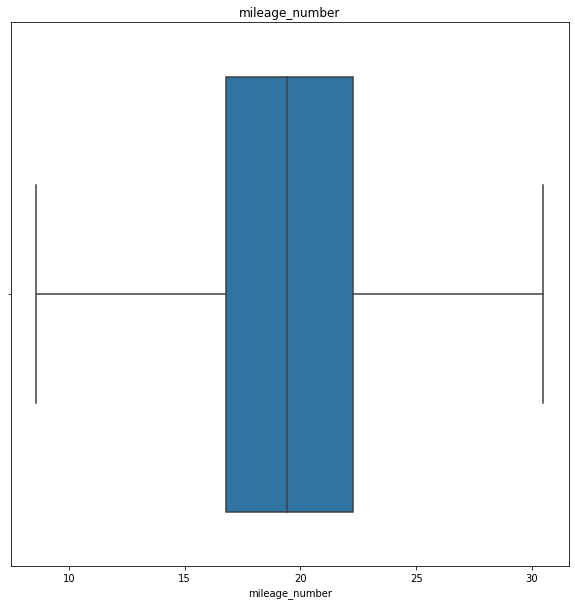

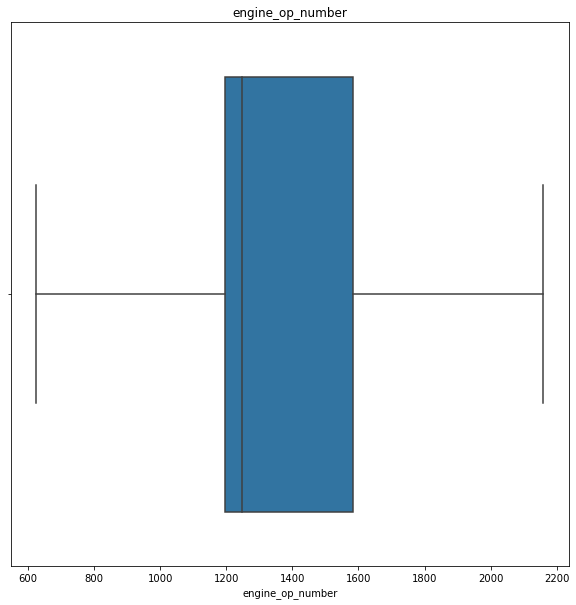

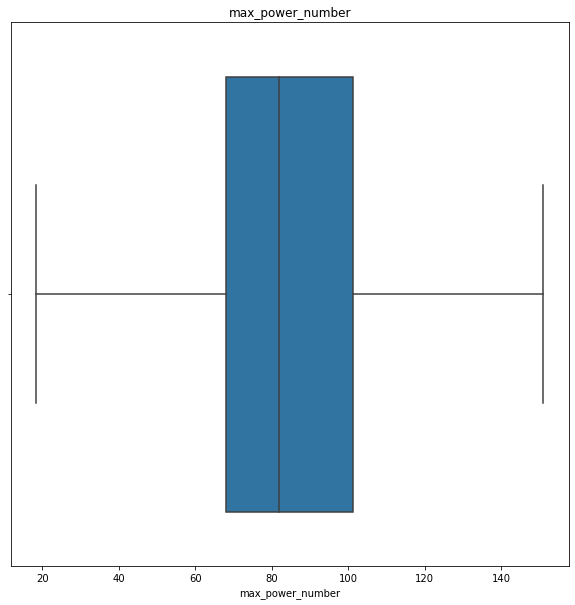

<Figure size 720x720 with 0 Axes>

In [38]:
for feature in numerical_cols:
    sns.boxplot(df_data[feature])
    plt.title(feature)
    plt.figure(figsize=(10,10))

## Feature Engineering

In [39]:
#Create a feature named 'Car_age' which is current_year-'year'

from datetime import date
todays_date = date.today()
print("Current year:", todays_date.year)

df_data['Car_age']=todays_date.year-df_data['year']

df_data.drop('year', axis=1, inplace=True)

Current year: 2022


## Feature Transformation

In [40]:
df_data.describe()

,selling_price,km_driven,torque,seats,mileage_number,engine_op_number,max_power_number,Car_age
count,8.128000e+03,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000
mean,5.155124e+05,68311.382013,172.420349,5.416719,19.433459,1416.605638,88.604125,8.160433
std,3.337026e+05,43569.154403,78.545915,0.946450,3.901041,406.157367,28.614950,3.914252
min,2.999900e+04,1.000000,39.200000,2.000000,8.583750,624.000000,18.375000,2.000000
25%,2.549990e+05,35000.000000,112.000000,5.000000,16.800000,1197.000000,68.100000,5.000000
50%,4.500000e+05,60000.000000,160.000000,5.000000,19.418783,1248.000000,81.860000,7.000000
75%,6.750000e+05,98000.000000,205.000000,5.000000,22.277500,1582.000000,101.250000,11.000000
max,1.305002e+06,192500.000000,344.500000,14.000000,30.493750,2159.500000,150.975000,20.000000


In [41]:
df_data2=df_data.copy(deep=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002240AAFC2B0>,
      dtype=object)

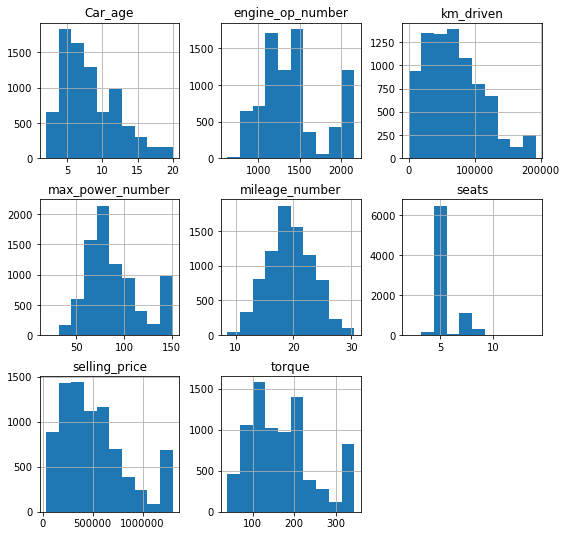

In [42]:
#data distribution in df
df_data2.hist(figsize=(9, 9))

In [43]:
numerical_cols = [cname for cname in df_data2.columns if df_data2[cname].dtypes!='object']
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_data2[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,selling_price,0.949759,0.949759,True
1,km_driven,0.741845,0.741845,True
2,torque,0.690393,0.690393,True
3,seats,1.996875,1.996875,True
4,mileage_number,0.012583,0.012583,False
5,engine_op_number,0.614328,0.614328,True
6,max_power_number,0.769032,0.769032,True
7,Car_age,0.819231,0.819231,True


In [44]:
#QQ plot
def plot_data(df):
    for feature in df.columns:
        print(feature)
        plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        df[feature].hist()
        plt.subplot(1,2,2)
        scipy.stats.probplot(df[feature],dist='norm',plot=pylab)
        plt.show()

In [45]:
#1.Apply log transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_data2[column+'_log'] = np.log(df_data2[column])

In [46]:
#2. Reciprocal transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_data2[column+'_rec']=1/(df_data2[column])

In [47]:
#3. Square root transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_data2[column+'_sqaure']=df_data2[column]**(1/2)

In [48]:
#4. Exponential transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_data2[column+'_exp']=df_data2[column]**(1/1.2)

In [49]:
def analyze_individual_feature_transf(df,feature):
    df_ft=df[[feature+'_log', feature+'_rec', feature+'_sqaure', feature+'_exp']].copy()
    plot_data(df_ft)

km_driven_log


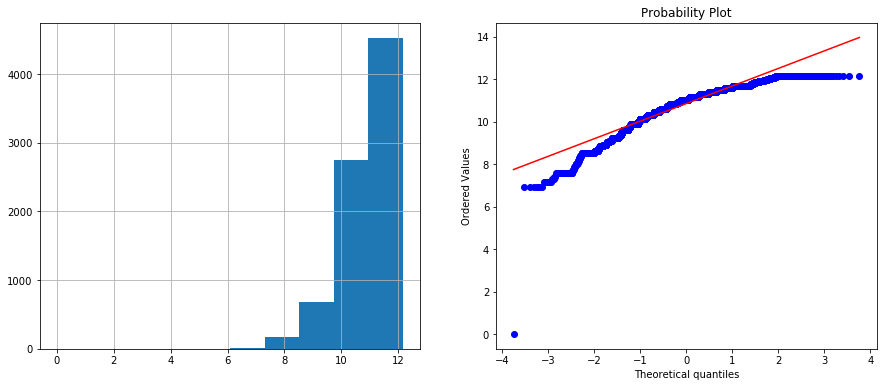

km_driven_rec


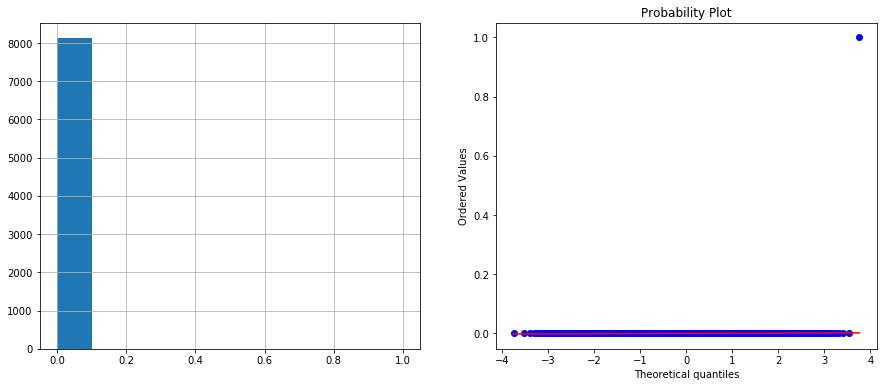

km_driven_sqaure


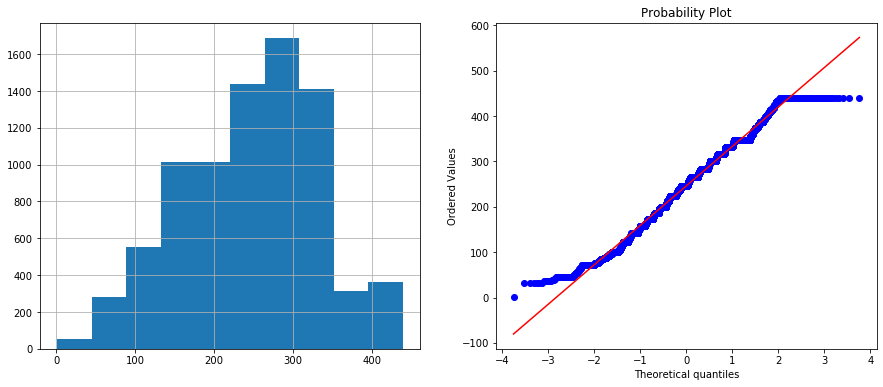

km_driven_exp


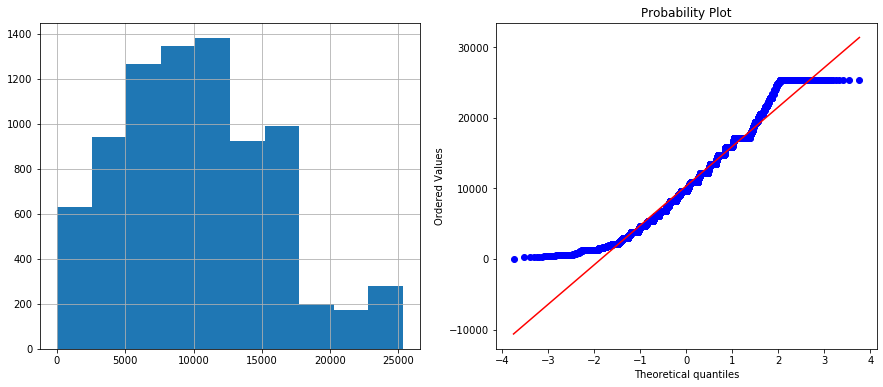

In [50]:
#Analyze the different feature transformation techniques for 'km_driven'
analyze_individual_feature_transf(df_data2, 'km_driven')

torque_log


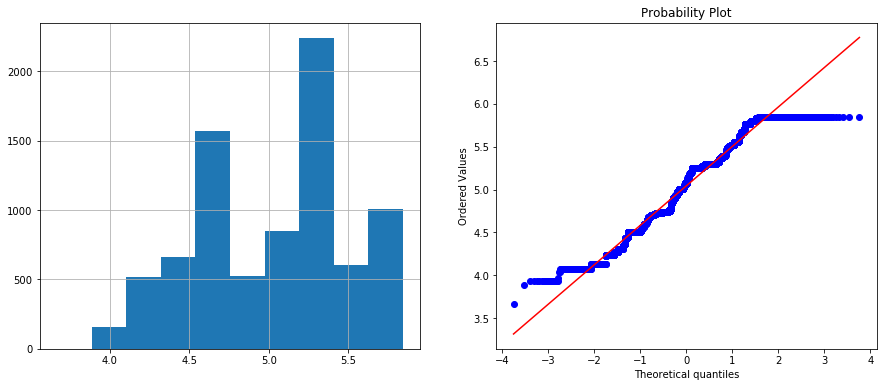

torque_rec


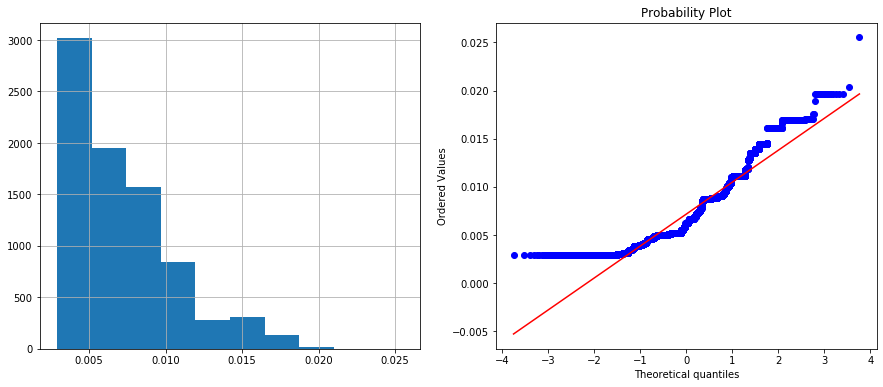

torque_sqaure


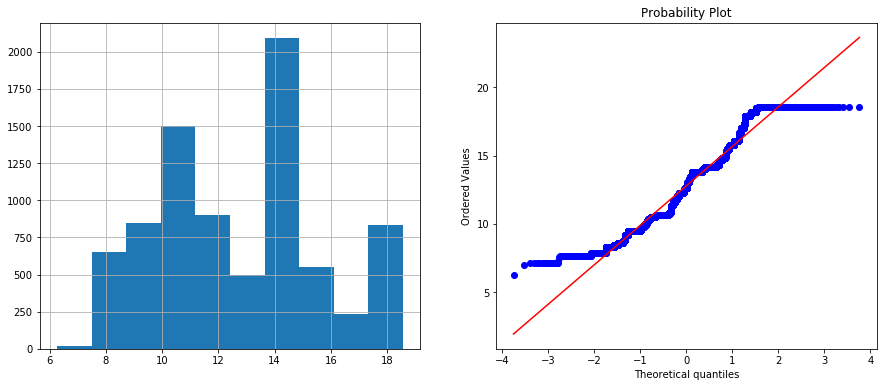

torque_exp


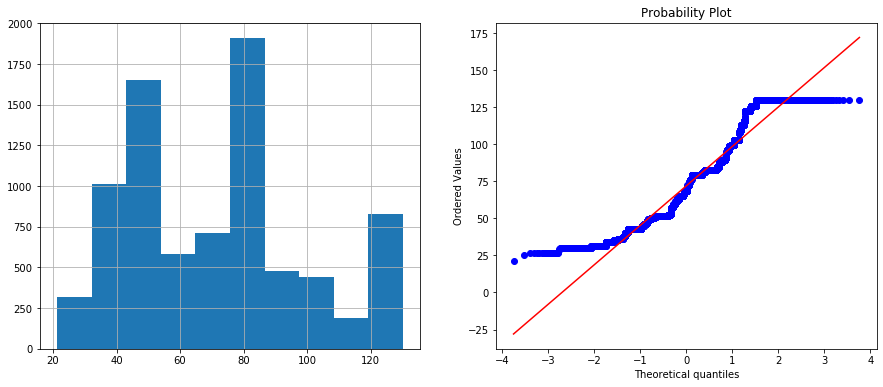

In [51]:
#Analyze the different feature transformation techniques for 'torque'
analyze_individual_feature_transf(df_data2, 'torque')

engine_op_number_log


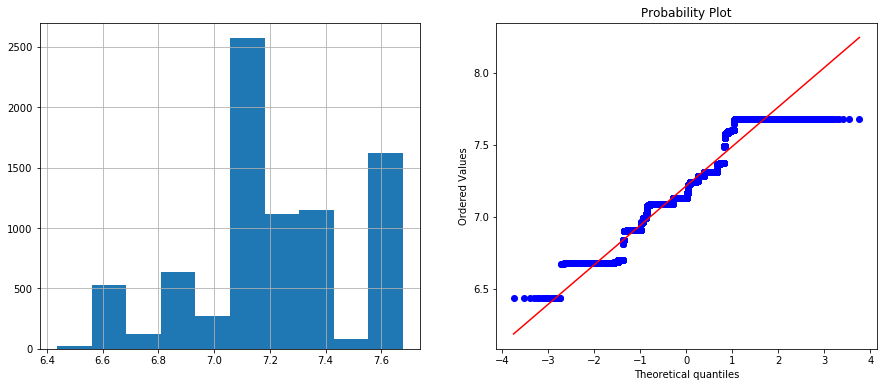

engine_op_number_rec


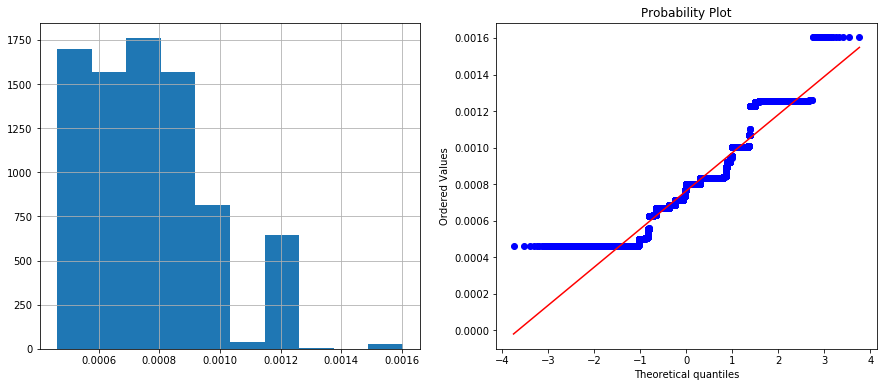

engine_op_number_sqaure


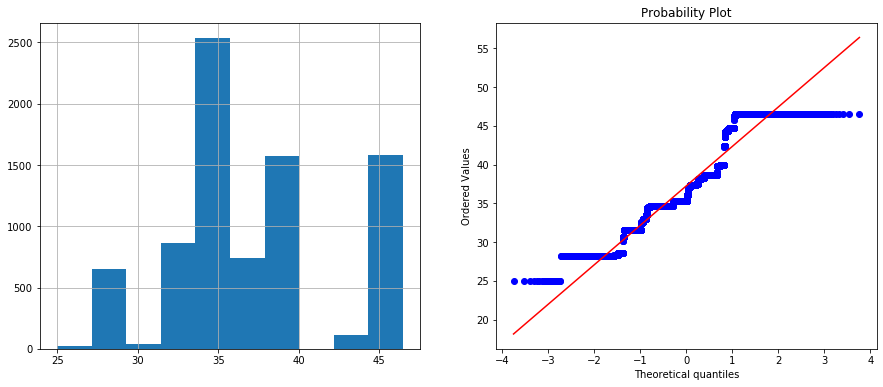

engine_op_number_exp


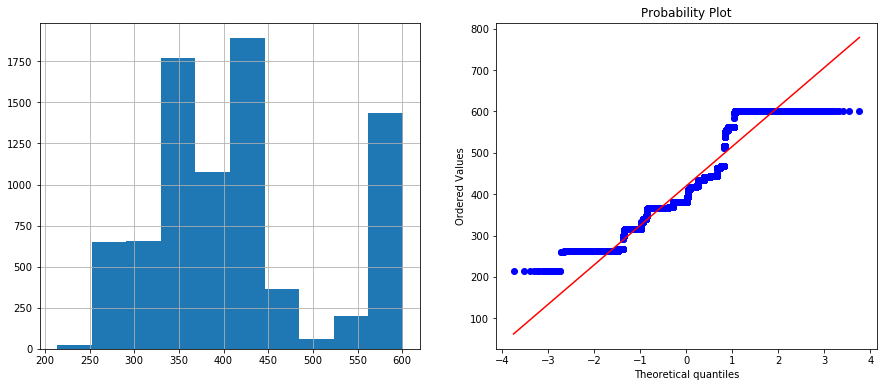

In [52]:
#Analyze the different feature transformation techniques for 'engine_op_number'
analyze_individual_feature_transf(df_data2, 'engine_op_number')

max_power_number_log


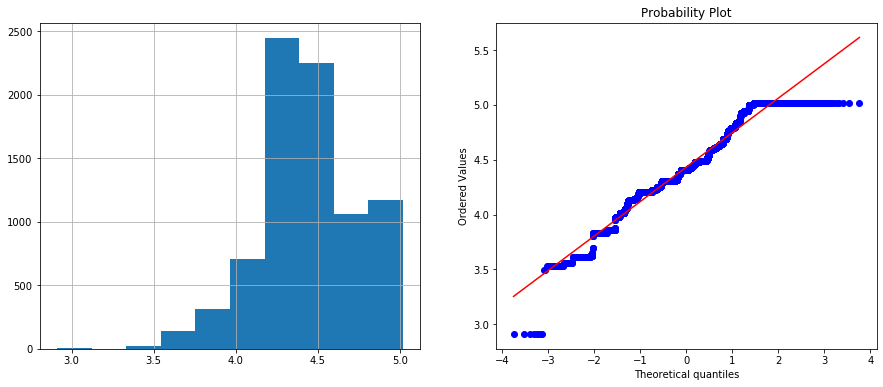

max_power_number_rec


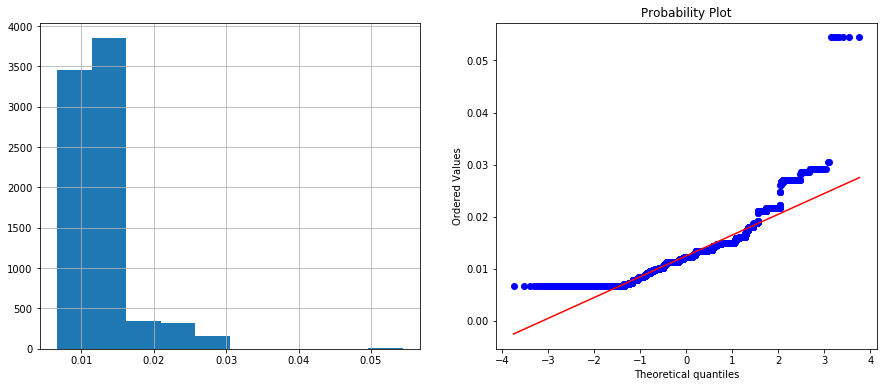

max_power_number_sqaure


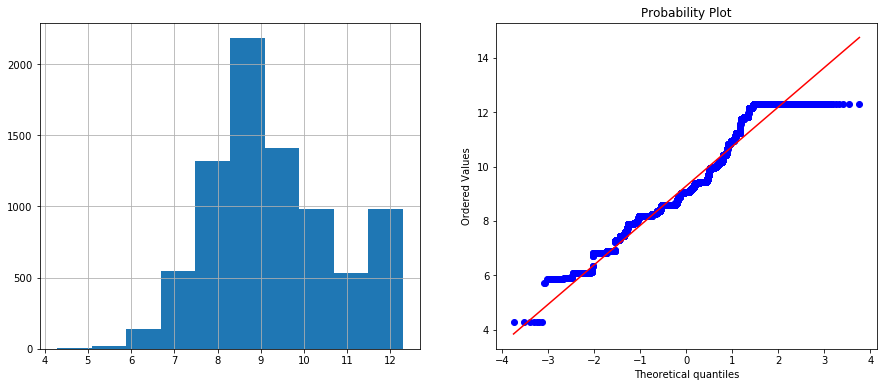

max_power_number_exp


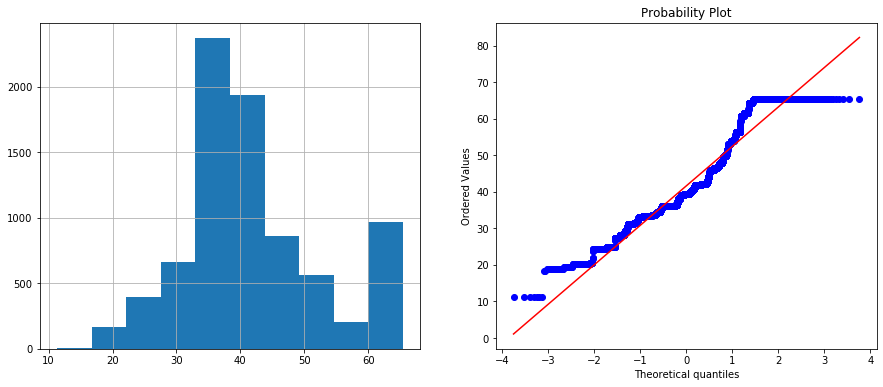

In [53]:
#Analyze the different feature transformation techniques for 'max_power_number'
analyze_individual_feature_transf(df_data2, 'max_power_number')

Car_age_log


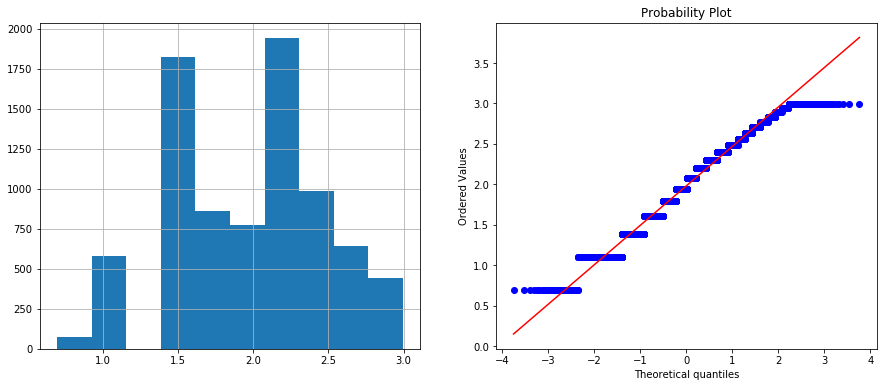

Car_age_rec


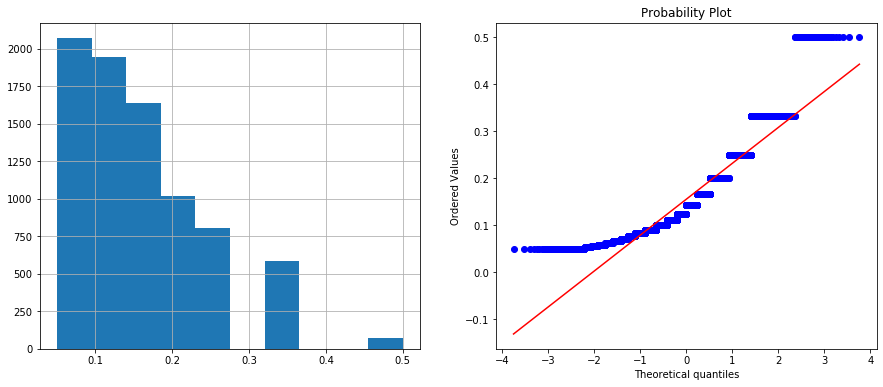

Car_age_sqaure


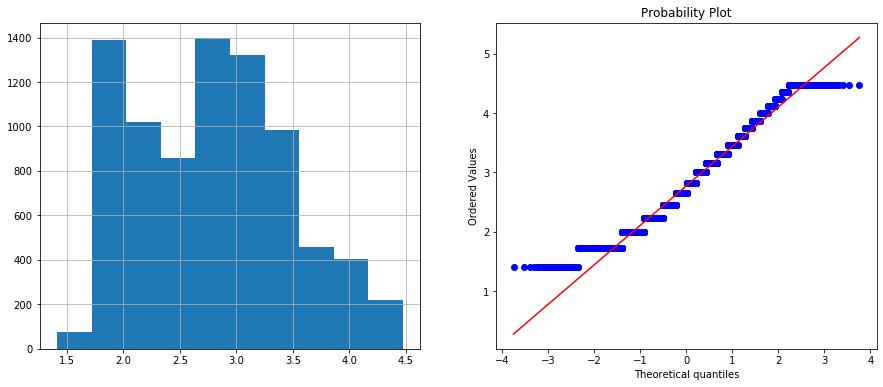

Car_age_exp


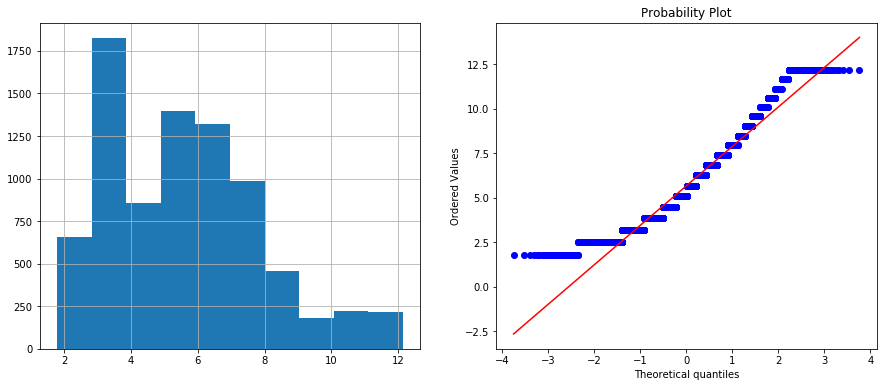

In [54]:
#Analyze the different feature transformation techniques for 'Car_age'
analyze_individual_feature_transf(df_data2, 'Car_age')

selling_price_log


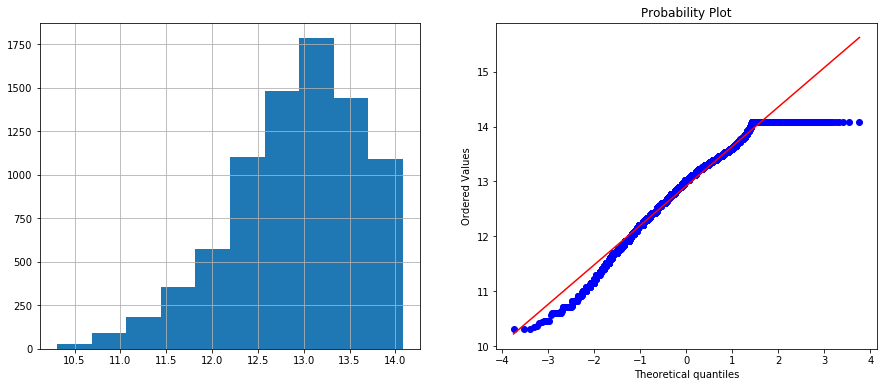

selling_price_rec


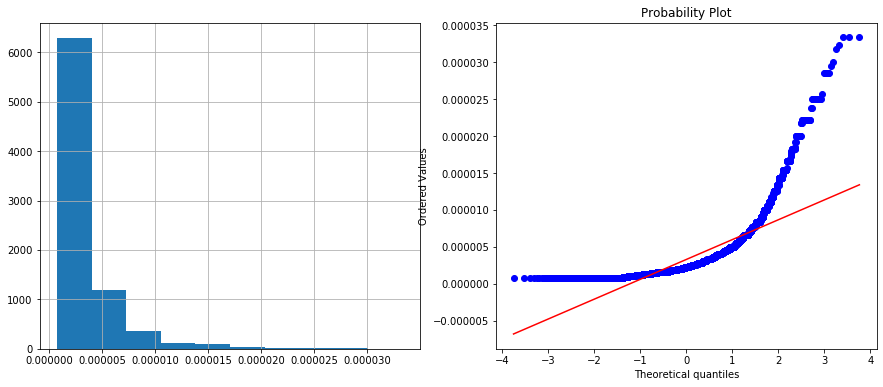

selling_price_sqaure


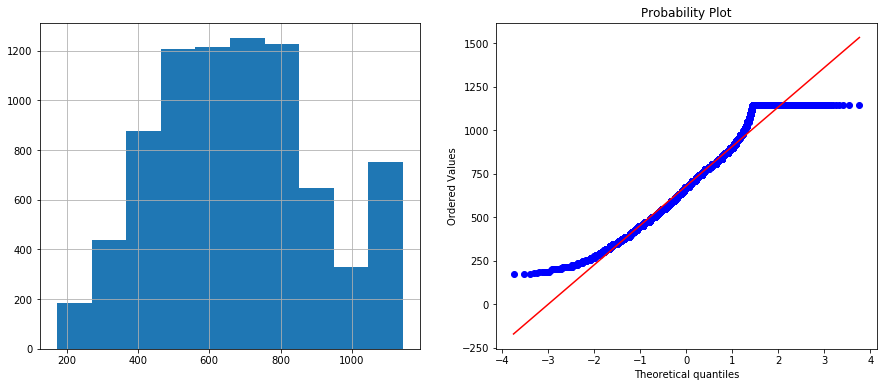

selling_price_exp


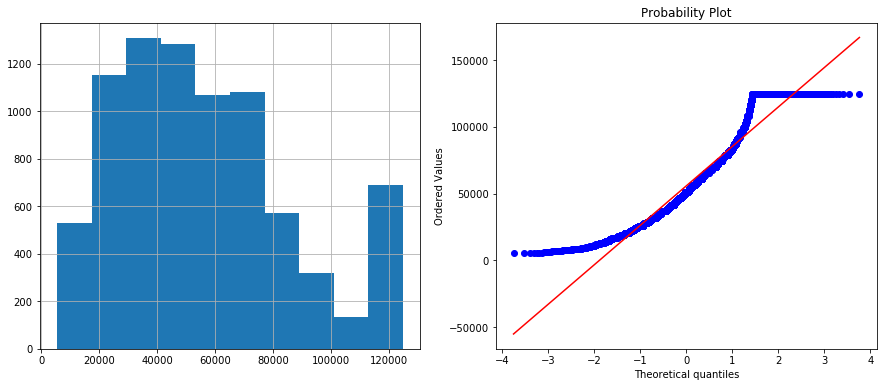

In [55]:
#Analyze the different feature transformation techniques for 'selling_price'
analyze_individual_feature_transf(df_data2, 'selling_price')

In [56]:
df_data3=df_data2[['mileage_number'
,'km_driven_sqaure'
,'torque_log'
,'seats'
,'engine_op_number_sqaure'
,'max_power_number_sqaure'
,'Car_age_log'
,'selling_price_log'
, 'fuel', 'seller_type', 'transmission','owner']].copy(deep=True)

In [57]:
df_data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
mileage_number             8128 non-null float64
km_driven_sqaure           8128 non-null float64
torque_log                 8128 non-null float64
seats                      8128 non-null float64
engine_op_number_sqaure    8128 non-null float64
max_power_number_sqaure    8128 non-null float64
Car_age_log                8128 non-null float64
selling_price_log          8128 non-null float64
fuel                       8128 non-null object
seller_type                8128 non-null object
transmission               8128 non-null object
owner                      8128 non-null object
dtypes: float64(8), object(4)
memory usage: 762.1+ KB


In [58]:
df_data3['max_power_number_sqaure'].min()

4.28660704987056

## Encoding categorical features

In [59]:
df_data4=df_data3.copy(deep=True)

In [60]:
df_data4['owner'] = df_data4['owner'].map({"Test Drive Car":1,"Fourth & Above Owner":2,"Third Owner":3,"Second Owner":4,"First Owner":5}).astype('int')

In [61]:
categorical_cols=[cname for cname in df_data4.columns if df_data4[cname].dtypes=='object']
print(categorical_cols)

['fuel', 'seller_type', 'transmission']


In [62]:
df_data_encoded = pd.get_dummies(df_data4[categorical_cols],drop_first=True)
df_data4.drop(categorical_cols,axis=1,inplace=True)
df_data4 = pd.concat([df_data4,df_data_encoded],axis=1)

df_data4.head()

,mileage_number,km_driven_sqaure,torque_log,seats,engine_op_number_sqaure,max_power_number_sqaure,Car_age_log,selling_price_log,owner,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark_Dealer,transmission_Manual
0,23.40,381.444622,5.247024,5.0,35.327043,8.602325,2.079442,13.017003,5,1,0,0,1,0,1
1,21.14,346.410162,5.521461,5.0,38.704005,10.174478,2.079442,12.821258,4,1,0,0,1,0,1
2,17.70,374.165739,4.767289,5.0,38.691084,8.831761,2.772589,11.970350,3,0,0,1,1,0,1
3,23.00,356.370594,5.373425,5.0,37.363083,9.486833,2.484907,12.323856,5,1,0,0,1,0,1
4,16.10,346.410162,4.680278,5.0,36.027767,9.391486,2.708050,11.775290,5,0,0,1,1,0,1


## Model building

In [63]:
X = df_data4.loc[:, df_data4.columns!='selling_price_log']
y = df_data4['selling_price_log']

In [64]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (5689, 14) (5689,)
Test (2439, 14) (2439,)


In [65]:
xgb_model=XGBRegressor(n_estimators=1000, larning_rate=0.05, n_jobs=-1)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

[18:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "larning_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', larning_rate=0.05,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
pred=xgb_model.predict(X_valid)

In [67]:
xgb_model.score(X_train, y_train)

0.9577097167044458

In [68]:
xgb_model.score(X_valid, y_valid)

0.9201975810594005

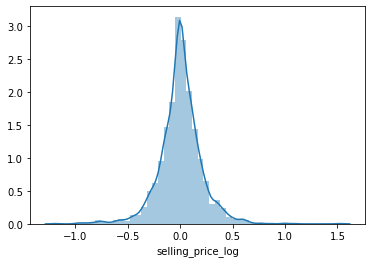

In [69]:
sns.distplot(y_valid-pred)

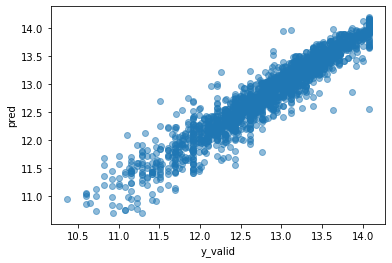

In [70]:
plt.scatter(y_valid, pred, alpha = 0.5)
plt.xlabel("y_valid")
plt.ylabel("pred")
plt.show()

In [71]:
print('MAE:', mean_absolute_error(y_valid, pred))
print('MSE:', mean_squared_error(y_valid, pred))
print('RMSE:', np.sqrt(mean_squared_error(y_valid, pred)))

MAE: 0.14129115559791475
MSE: 0.041826540674420626
RMSE: 0.20451538004370387


In [72]:
r2_score(y_valid, pred)

0.9201975810594005

## Save the model

In [75]:
import pickle
# open a file, where you ant to store the data
file = open('carprice_xgb.pkl', 'wb')

# dump information to that file
pickle.dump(xgb_model, file)

In [76]:
model = open('carprice_xgb.pkl','rb')
xgb_regressor = pickle.load(model)

In [77]:
y_prediction = xgb_regressor.predict(X_valid)

In [78]:
r2_score(y_valid, y_prediction)

0.9201975810594005

In [81]:
model_ip=[10, 141.4213562373095, 3.6888794541139363, 40, 6.324555320336759, 6.324555320336759, 3.7376696182833684, 5, 1, 0, 0, 0, 0, 0 ]

In [85]:
np_array=np.asarray(model_ip)

In [86]:
model_ip=np_array.reshape(1,-1)

In [87]:
op=xgb_model.predict(model_ip)

In [89]:
print(np.exp(op))

[57455.555]
